In [2]:
import sys
import warnings
sys.path.append("..")

from data.data_loader import normalised_subspace, subspace, scaler
from synthetic_anomalies.generation import anomaly_dataset
import seaborn as sns

from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

from benchmark import anom_types, models, model_outputs, init_algos
from evaluation import algo_results, algo_rank_results, result_df, plot_results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scienceplots
plt.style.use('science')

In [3]:
output = anomaly_dataset(
    anom_size=1000
)

In [3]:
tsne = TSNE()
X_embed = tsne.fit_transform(output.to_numpy()[:, 0:5])

output["tsne_x"] = X_embed[:, 0]
output["tsne_y"] = X_embed[:, 1]

/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_10120/3284612127.py:110: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_10120/3284612127.py:111: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_10120/3284612127.py:112: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[2]._sizes = [30]
/var/folders/44/yjf9jwgd1bqfct8dx076vwqm0000gn/T/ipykernel_10120/3284612127.py:113: MatplotlibDeprecationWarning: The legendHandles a

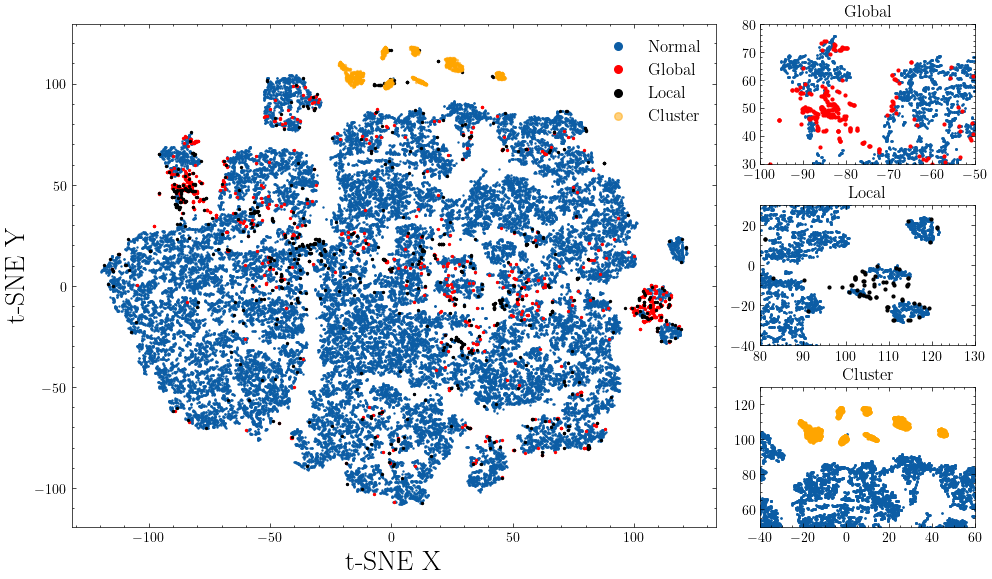

In [4]:
fig = plt.figure(figsize=(10, 6))

# Create a grid for the main plot and the panel
main_grid = fig.add_gridspec(1, 2, width_ratios=[3, 1])

# Main plot
main_plot = fig.add_subplot(main_grid[0, 0])

main_plot.scatter(
    output[output["label"] == 0]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=.5,
    marker="o",
    label="Normal"
)
main_plot.scatter(
    output[output["label"] == 1]["tsne_x"],
    output[output["label"] == 1]["tsne_y"],
    s=2,
    marker="o",
    c="r",
    label="Global"
)
main_plot.scatter(
    output[output["label"] == 2]["tsne_x"],
    output[output["label"] == 2]["tsne_y"],
    s=2,
    marker="o",
    c="black",
    label="Local"
)
main_plot.scatter(
    output[output["label"] == 3]["tsne_x"],
    output[output["label"] == 3]["tsne_y"],
    s=2,
    marker="o",
    c="orange",
    alpha=.5,
    label="Cluster"
)

main_plot.set_xlabel("t-SNE X", fontsize=20)
main_plot.set_ylabel("t-SNE Y", fontsize=20)

# Panel with subplots
panel_grid = main_grid[0, 1].subgridspec(3, 1, hspace=0.3)

# Create three smaller subplots in the panel
#for i in range(3):
ax = fig.add_subplot(panel_grid[0, 0])
ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 1)]["tsne_x"],
    output[output["label"] == 1]["tsne_y"],
    s=4,
    marker="o",
    c="r"
)


ax.set_xlim(-100,-50)
ax.set_ylim(30,80)
ax.set_title(f"Global")

ax = fig.add_subplot(panel_grid[1, 0])

ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 2)]["tsne_x"],
    output[output["label"] == 2]["tsne_y"],
    s=4,
    marker="o",
    c="black"
)
ax.set_xlim(80,130)
ax.set_ylim(-40,30)
ax.set_title(f"Local")

ax = fig.add_subplot(panel_grid[2, 0])
ax.scatter(
    output[(output["label"] == 0)]["tsne_x"],
    output[output["label"] == 0]["tsne_y"],
    s=1,
    marker="o",
)
ax.scatter(
    output[(output["label"] == 3)]["tsne_x"],
    output[output["label"] == 3]["tsne_y"],
    s=4,
    marker="o",
    c="orange",
)
ax.set_ylim(50, 130)
ax.set_xlim(-40,60)
ax.set_title(f"Cluster")

# Adjust layout
plt.tight_layout()
legend = main_plot.legend(loc="upper right", fontsize=12, scatterpoints=1)
legend.legendHandles[0]._sizes = [30]
legend.legendHandles[1]._sizes = [30]
legend.legendHandles[2]._sizes = [30]
legend.legendHandles[3]._sizes = [30]

#plt.savefig("anom_types.png", dpi=500)
# Show the plot
plt.show()

In [4]:
global_df = output[~((output["label"] == 1) & (output["score"] >= 0)) & ((output["label"] == 1) | (output["label"] == 0))]
contamination_global = len(global_df[global_df["label"] == 1])/len(global_df)
global_df = global_df.to_numpy()

In [5]:
contamination_global

0.0075623747047498064

In [16]:
cluster_df = output[~((output["label"] == 3) & (output["score"] >= 0)) & ((output["label"] == 3) | (output["label"] == 0))]
contamination_cluster = len(cluster_df[cluster_df["label"] == 3])/len(cluster_df)
cluster_df = cluster_df.to_numpy()

In [11]:
local_df = output[(output["label"] == 0) | (output["label"] == 2)].to_numpy()
contamination_local = len(output[output["label"] == 2])/len(local_df)

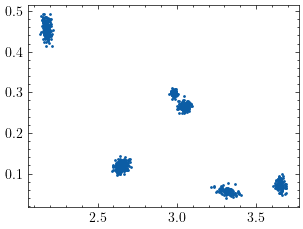

In [8]:
plt.scatter(
    output[output["label"] == 3].to_numpy()[:, 2], output[output["label"] == 3].to_numpy()[:, 3], s=1
)

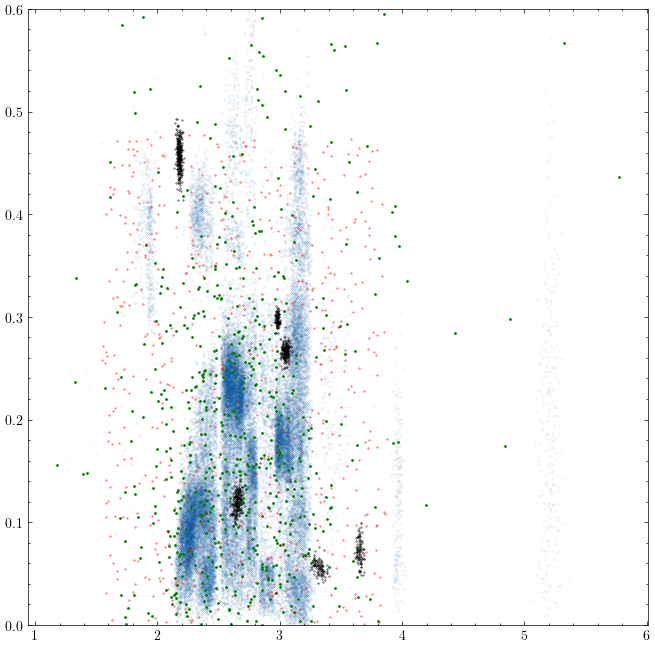

In [9]:
plt.subplots(figsize=(8,8))
plt.ylim(0, .6)
plt.scatter(
    output[output["label"] == 0].to_numpy()[:, 2], output[output["label"] == 0].to_numpy()[:, 3], s=.01, alpha=.5
)
plt.scatter(
    output[output["label"] == 2].to_numpy()[:, 2], output[output["label"] == 2].to_numpy()[:, 3], s=1, c="green"
)
plt.scatter(
    output[output["label"] == 1].to_numpy()[:, 2], output[output["label"] == 1].to_numpy()[:, 3], s=.1, c="red"
)

plt.scatter(
    output[output["label"] == 3].to_numpy()[:, 2], output[output["label"] == 3].to_numpy()[:, 3], s=.1, c="black"
)

## Local anomalies

In [13]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    local_scores_with_noise = algo_results(
        data = local_df,
        models = init_algos(
            contamination = contamination_local
        ),
        label = 2,
        noise_level = .25,
        with_noise = True
    )

KNN
Accuracy metric: {'BAL_ACC': [0.717883031935802, 0.7301141130821164, 0.7131727137731048, 0.7008083081817534, 0.7009749637380497, 0.698619804656701, 0.727925609557064, 0.7305474175284866, 0.7048853352305249, 0.7153945484094164], 'F1': [0.4497816593886463, 0.44948453608247424, 0.43162393162393164, 0.42696629213483145, 0.4318181818181818, 0.4224719101123595, 0.445360824742268, 0.46186440677966106, 0.4273127753303964, 0.436830835117773]})
------
IForest
Accuracy metric: {'BAL_ACC': [0.6431406009714296, 0.6230440959108473, 0.6411520841139327, 0.625132606102122, 0.6474842769102749, 0.6164785853356902, 0.6297429309310414, 0.6415520574490436, 0.6556716621190771, 0.6293762887071896], 'F1': [0.2948717948717949, 0.25000000000000006, 0.2943722943722944, 0.25258799171842644, 0.302771855010661, 0.2375, 0.2647058823529412, 0.3022222222222223, 0.30864197530864196, 0.2587268993839836]})
------
LOF
Accuracy metric: {'BAL_ACC': [0.7282255895583972, 0.7346244445772581, 0.7191049332343361, 0.7071405009

In [14]:
local_results = result_df(
    local_scores_with_noise, anom_type = "local"
).drop(columns=["type"]).groupby(by=["Algorithm", "metric"])#.mean()

In [15]:
local_results.describe()

score                                          \
                        count      mean       std       min       25%   
Algorithm       metric                                                  
ABOD            BAL_ACC  10.0  0.714904  0.010188  0.700175  0.710243   
                F1       10.0  0.434609  0.017694  0.409483  0.418785   
CBLOF           BAL_ACC  10.0  0.583610  0.013942  0.558489  0.572986   
                F1       10.0  0.178242  0.024869  0.134228  0.161405   
CD              BAL_ACC  10.0  0.665113  0.062153  0.525862  0.659566   
                F1       10.0  0.149693  0.116399  0.045977  0.058345   
COPOD           BAL_ACC  10.0  0.631677  0.015601  0.612435  0.618073   
                F1       10.0  0.281619  0.028242  0.234043  0.269315   
Feature Bagging BAL_ACC  10.0  0.718465  0.008059  0.700775  0.714559   
                F1       10.0  0.442932  0.008636  0.426009  0.440692   
HBOS            BAL_ACC  10.0  0.641141  0.008115  0.628354  0.635589   
                F1       10.0  0.290418  0.012646  0.270042  0.281860   
IForest         BAL_ACC  10.0  0.635278  0.012347  0.616479  0.626194   
                F1       10.0  0.276640  0.026440  0.237500  0.254123   
KNN             BAL_ACC  10.0  0.714033  0.012510  0.698620  0.701953   
                F1       10.0  0.438352  0.012695  0.422472  0.428391   
LOF             BAL_ACC  10.0  0.716322  0.017006  0.689866  0.703558   
                F1       10.0  0.434020  0.026067  0.396624  0.415334   

                                                       
                              50%       75%       max  
Algorithm       metric                                 
ABOD            BAL_ACC  0.713800  0.720874  0.734591  
                F1       0.435972  0.447774  0.460581  
CBLOF           BAL_ACC  0.589139  0.590933  0.600892  
                F1       0.185682  0.196326  0.207188  
CD              BAL_ACC  0.670413  0.701683  0.739959  
                F1       0.082389  0.259194  0.325380  
COPOD           BAL_ACC  0.629482  0.643093  0.656272  
                F1       0.278867  0.303863  0.320513  
Feature Bagging BAL_ACC  0.719805  0.721835  0.728292  
                F1       0.443017  0.446677  0.455696  
HBOS            BAL_ACC  0.642230  0.645504  0.655605  
                F1       0.291630  0.300123  0.307377  
IForest         BAL_ACC  0.635448  0.642743  0.655672  
                F1       0.279539  0.300385  0.308642  
KNN             BAL_ACC  0.714284  0.725415  0.730547  
                F1       0.434325  0.448454  0.461864  
LOF             BAL_ACC  0.715922  0.731333  0.739135  
                F1       0.430367  0.455060  0.473795

## Global anomalies

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    global_scores_with_noise = algo_results(
    data = global_df,
    models = init_algos(
        contamination = contamination_global
    ),
    label = 1,
    noise_level=.25
)

KNN
Accuracy metric: {'BAL_ACC': [0.8273141439693494, 0.7833211704015054, 0.7883737575389711, 0.8448913347297315, 0.8011983411632206, 0.7882404330939341, 0.8137562758973963, 0.8272474817468309, 0.7837544748478756, 0.7877404664250454], 'F1': [0.6302521008403361, 0.5603448275862069, 0.619718309859155, 0.6556016597510375, 0.6106194690265486, 0.608294930875576, 0.5829959514170041, 0.625, 0.593607305936073, 0.5689655172413793]})
------
IForest
Accuracy metric: {'BAL_ACC': [0.6729720942580436, 0.6821773285289753, 0.6721388164765624, 0.7260369776517823, 0.6462896625605077, 0.6993545459542463, 0.6727721075904881, 0.6995545326218018, 0.6690527649033924, 0.642037022093264], 'F1': [0.3508771929824561, 0.3870967741935483, 0.3162055335968379, 0.4581497797356828, 0.2918454935622318, 0.39655172413793105, 0.3418803418803419, 0.4070796460176991, 0.3661971830985915, 0.2894736842105263]})
------
LOF
Accuracy metric: {'BAL_ACC': [0.6778913569504723, 0.6907159405747219, 0.6815773685263088, 0.66878611601331

In [9]:
global_results = result_df(
    global_scores_with_noise, anom_type = "global"
).groupby(by=["Algorithm", "metric"])

In [10]:
global_results.describe()

score                                          \
                        count      mean       std       min       25%   
Algorithm       metric                                                  
ABOD            BAL_ACC  10.0  0.739972  0.025039  0.699655  0.730440   
                F1       10.0  0.472881  0.038199  0.408333  0.465941   
CBLOF           BAL_ACC  10.0  0.501363  0.003483  0.495934  0.499795   
                F1       10.0  0.010334  0.006902  0.000000  0.007915   
CD              BAL_ACC  10.0  0.658401  0.041861  0.589372  0.624740   
                F1       10.0  0.273419  0.049359  0.193548  0.234437   
COPOD           BAL_ACC  10.0  0.642130  0.021303  0.611335  0.630167   
                F1       10.0  0.292682  0.036843  0.235294  0.275618   
Feature Bagging BAL_ACC  10.0  0.689363  0.029415  0.616321  0.682791   
                F1       10.0  0.384322  0.051037  0.264706  0.370182   
HBOS            BAL_ACC  10.0  0.728835  0.026648  0.686930  0.711899   
                F1       10.0  0.471687  0.038776  0.415459  0.442657   
IForest         BAL_ACC  10.0  0.678239  0.025190  0.642037  0.669824   
                F1       10.0  0.360536  0.053649  0.289474  0.322624   
KNN             BAL_ACC  10.0  0.804584  0.022236  0.783321  0.787865   
                F1       10.0  0.605540  0.029365  0.560345  0.585649   
LOF             BAL_ACC  10.0  0.702827  0.024136  0.668786  0.683862   
                F1       10.0  0.399317  0.032735  0.352941  0.379858   

                                                       
                              50%       75%       max  
Algorithm       metric                                 
ABOD            BAL_ACC  0.739278  0.746779  0.782788  
                F1       0.476395  0.492898  0.524194  
CBLOF           BAL_ACC  0.500736  0.504806  0.505305  
                F1       0.008909  0.017022  0.018182  
CD              BAL_ACC  0.669563  0.692047  0.710913  
                F1       0.288113  0.304779  0.346290  
COPOD           BAL_ACC  0.637518  0.659126  0.676625  
                F1       0.277056  0.325189  0.352381  
Feature Bagging BAL_ACC  0.696878  0.704024  0.721684  
                F1       0.383484  0.418085  0.453333  
HBOS            BAL_ACC  0.724294  0.745757  0.778902  
                F1       0.477618  0.487786  0.551724  
IForest         BAL_ACC  0.672872  0.695060  0.726037  
                F1       0.358537  0.394188  0.458150  
KNN             BAL_ACC  0.794786  0.823875  0.844891  
                F1       0.609457  0.623680  0.655602  
LOF             BAL_ACC  0.699271  0.720096  0.738828  
                F1       0.398153  0.422632  0.456432

## Cluster anomalies

In [17]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    cluster_scores_with_noise = algo_results(
        data = cluster_df,
        models = init_algos(
            contamination_cluster
        ),
        label = 3.,
        noise_level=.25
    )

KNN
Accuracy metric: {'BAL_ACC': [0.49099220635899216, 0.49355870192595436, 0.494516910551462, 0.4900006666222252, 0.4929920730345471, 0.49205880191928814, 0.49282541747825087, 0.496041748068377, 0.4918254841404734, 0.49505020833161], 'F1': [0.003333333333333333, 0.0038240917782026763, 0.007272727272727273, 0.0, 0.003703703703703704, 0.0035211267605633804, 0.003669724770642202, 0.010714285714285716, 0.0034782608695652175, 0.00749063670411985]})
------
IForest
Accuracy metric: {'BAL_ACC': [0.9405725749670217, 0.8574891844193355, 0.9367229532629698, 0.9091507038216917, 0.9349981290784994, 0.9258407103759992, 0.8473651634903172, 0.8945854947869656, 0.9332733048940289, 0.912800338858188], 'F1': [0.8848263254113344, 0.7419962335216572, 0.8711433756805806, 0.8302583025830259, 0.8738574040219378, 0.861878453038674, 0.6906474820143884, 0.8142589118198874, 0.8766114180478822, 0.8345588235294118]})
------
LOF
Accuracy metric: {'BAL_ACC': [0.5081239109606804, 0.5023494784046028, 0.505499146772210

In [18]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    cluster_results = result_df(
        cluster_scores_with_noise, anom_type = "cluster"
    ).groupby(by=["Algorithm", "metric"]).describe()
    cluster_results

## Global ranking

In [19]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    global_rank_scores_with_noise = algo_rank_results(
        data = global_df,
        models = init_algos(
            contamination = contamination_global
        ),
        label = 1,
        #with_noise = False,
        noise_level=.25
    )

In [20]:
pd.DataFrame(global_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000
mean,0.761200,0.479200,0.417000,0.702200,0.392200,0.520600,0.470400,0.464600,0.50700
std,0.015002,0.034797,0.024445,0.017087,0.034208,0.014909,0.016754,0.024874,0.01212
min,0.732000,0.428000,0.378000,0.676000,0.358000,0.496000,0.446000,0.422000,0.48600
25%,0.752000,0.455000,0.403000,0.689500,0.363500,0.510500,0.456500,0.456000,0.49750
50%,0.762000,0.481000,0.406000,0.701000,0.384000,0.521000,0.469000,0.459000,0.51100
75%,0.769500,0.499000,0.439000,0.713000,0.415000,0.534000,0.482000,0.478000,0.51350
max,0.786000,0.534000,0.452000,0.732000,0.446000,0.538000,0.494000,0.510000,0.52400


## Cluster ranking evaluation

In [21]:

cluster_rank_scores_with_noise = algo_rank_results(
    data = cluster_df,
    models = init_algos(
        contamination = contamination_global
    ),
    label = 3,
    #with_noise = False,
    noise_level= .25
)

/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/br/Desktop/lsst_ad_git/ad_lsst/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: Fut

In [22]:
pd.DataFrame(cluster_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.398400,0.643600,0.219800,0.366400,0.630600,0.660800,0.478800,0.303200,0.504800
std,0.011187,0.019179,0.009496,0.008834,0.012474,0.019982,0.013959,0.027312,0.032731
min,0.374000,0.618000,0.204000,0.350000,0.602000,0.630000,0.456000,0.256000,0.460000
25%,0.392000,0.629000,0.214500,0.362000,0.630000,0.645500,0.471500,0.285000,0.492000
50%,0.401000,0.643000,0.217000,0.367000,0.633000,0.665000,0.478000,0.302000,0.499000
75%,0.406500,0.657000,0.227000,0.369500,0.638500,0.675000,0.487000,0.323000,0.524500
max,0.410000,0.672000,0.234000,0.382000,0.644000,0.684000,0.500000,0.348000,0.566000


## Local ranking evaluation

In [23]:
import joblib 
from evaluation import algo_rank_local_results

anom_gen = joblib.load(open("../synthetic_anomalies/gmm/gmm.joblib", "rb"))
params = anom_gen._get_parameters()

In [24]:
arr = np.vectorize(lambda x: params[1][int(x)][0])(local_df[:, 7]).reshape(-1, 1)
for i in range(1, 5):
    arr = np.hstack((arr, np.vectorize(lambda x: params[1][int(x)][int(i)])(local_df[:, 7]).reshape(-1, 1)))

centroid_dist = np.linalg.norm(scaler.inverse_transform(arr) - local_df[:, 0:5], axis=1)

scaled_centroid_dist = (centroid_dist - centroid_dist.min())
scaled_centroid_dist /= scaled_centroid_dist.max()

In [25]:
from sklearn.model_selection import train_test_split

def algo_rank_local_results(data, label, iterations = 10, with_noise=True, noise_level = 0, silent = False):
    rank_scores = {key : [] for key in models}
    '''if anom_type == "local":
        idx = -1
    else:'''
    idx = -1

    for i in range(iterations):
        if with_noise:
            duplicate_idx = np.random.choice(500, size=100, replace=False)

            noisy_features = data[:, :5] + noise_level*data[:, -6:-1]
            noisy_features =  np.concatenate([noisy_features, noisy_features[duplicate_idx, 0:5]]) # Add duplicates

            noisy_scores = np.concatenate([data[:, idx], data[duplicate_idx, idx]])
            noisy_labels = np.concatenate([data[:, 5], data[duplicate_idx, 5]])

            # Should I make use of training score?
            X_train, X_test, y_train, y_test = train_test_split(
                noisy_features, 
                noisy_scores, 
                test_size=.3,
                #random_state=42,
                stratify=noisy_labels,
                shuffle=True
            )
                    
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                data[:, 0:5], 
                data[:, idx], # score column of dataset
                test_size=.3,
                #random_state=42,
                stratify=data[:, 5],
                shuffle=True
            )

        rn_model_idx = np.argsort(y_test)[-500::]

        for name, clf in zip(models.keys(), models.values()):
            
            clf.fit(X_train)
            # get the prediction labels and outlier scores of the training data
            #y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
            #y_train_scores = clf.decision_scores_  # raw outlier scores
            

            # get the prediction on the test data
            #y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
            y_test_scores = clf.decision_function(X_test)  # outlier scoress
            
            '''rn_algo_scores = y_test_scores - y_test_scores.min()
            rn_algo_scores /= rn_algo_scores.max()
            
            rn_model_scores = abs(y_test - y_test.max())
            rn_model_scores /= rn_model_scores.max()
            '''
            #acc = balanced_accuracy_score(y_test, label*y_test_pred)
            #model_scores = anom_gen.gmm.score_samples(X_test)
            ''' print(np.argsort(y_test_scores)[::-1])
                print(np.argsort(y_test))'''
            #print(y_test_scores, model_scores.min())


            err_score = len(np.intersect1d(rn_model_idx, np.argsort(y_test_scores)[-500::])) / 500 # Overlap of the top 100 outliers.
            rank_scores[name].append(err_score)
            
            #rank_scores[name].append(kendalltau(rn_model_scores, rn_algo_scores).correlation)
            #print(f"Name: {name}, spearman: {spearmanr(rn_model_scores, rn_algo_scores)}")
            '''if not silent:
                print(name)
                print(f"Accuracy metric: {rank_scores[name]})")
                print(("------"))'''

    return rank_scores

In [26]:
with warnings.catch_warnings(): # Remove parameter update warning from sklearn implementatio - clean output, that's all.
    warnings.simplefilter("ignore")
    local_rank_scores_with_noise = algo_rank_local_results(
        data = np.hstack((local_df, scaled_centroid_dist.reshape(-1,1))),
        label = 2,
        #with_noise = False,
        noise_level=.25
    )

In [ ]:
pd.DataFrame(local_rank_scores_with_noise).describe()

,KNN,IForest,LOF,ABOD,CBLOF,CD,COPOD,Feature Bagging,HBOS
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.087800,0.606600,0.096000,0.118000,0.143600,0.534000,0.526400,0.163600,0.446200
std,0.014921,0.033929,0.012074,0.013952,0.014901,0.057069,0.016621,0.030938,0.113178
min,0.054000,0.562000,0.074000,0.098000,0.126000,0.378000,0.492000,0.106000,0.252000
25%,0.084000,0.594000,0.089500,0.110500,0.130000,0.542000,0.517500,0.146500,0.360500
50%,0.087000,0.604000,0.096000,0.115000,0.142000,0.549000,0.531000,0.162000,0.495000
75%,0.093500,0.617000,0.100000,0.122500,0.155500,0.560000,0.533500,0.188000,0.501500
max,0.108000,0.686000,0.118000,0.148000,0.170000,0.580000,0.556000,0.204000,0.566000
